In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"D:\Ali\SQL\Projects\BlinkIt\Python Project - Blinkit - Grocery Product Analysis16953853410.txt")
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [3]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [4]:
#Checking null
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

Item_Weight    1463
Outlet_Size    2410
dtype: int64


In [5]:
#filling null values
df['Item_Weight'] = df['Item_Weight'].fillna(
df.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())

mode_mapping = df.groupby('Outlet_Type')['Outlet_Size'].transform(
lambda x: x.mode()[0] if not x.mode().empty else 'Medium')
df['Outlet_Size'] = df['Outlet_Size'].fillna(mode_mapping)

In [6]:
#Checking Duplicates or repeatead and inconsistent
print(f"Total duplicate rows: {df.duplicated().sum()}")

duplicate_columns = df.apply(lambda x: x.duplicated().sum())
print("\nDuplicates per column:")
print(duplicate_columns[duplicate_columns > 0])

item_fat_counts = df['Item_Fat_Content'].value_counts()
print("\nInconsistent categories in Item_Fat_Content:")
print(item_fat_counts)

Total duplicate rows: 0

Duplicates per column:
Item_Identifier              6964
Item_Weight                  8076
Item_Fat_Content             8518
Item_Visibility               643
Item_Type                    8507
Item_MRP                     2585
Outlet_Identifier            8513
Outlet_Establishment_Year    8514
Outlet_Size                  8520
Outlet_Location_Type         8520
Outlet_Type                  8519
Item_Outlet_Sales            5030
dtype: int64

Inconsistent categories in Item_Fat_Content:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


In [7]:
# Standardizing Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

# Verify the result
print(df['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


In [8]:
import numpy as np

# Replacing 0 with NaN so we can fill them properly
df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)

# Filling NaN with the mean visibility of that specific Item_Identifier
df['Item_Visibility'] = df['Item_Visibility'].fillna(
    df.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

# If any still remain (items with only 0 visibility), filling with global mean
df['Item_Visibility'] = df['Item_Visibility'].fillna(df['Item_Visibility'].mean())

In [9]:
# Dropping the Establishment Year as it's not very useful
df = df.drop('Outlet_Establishment_Year', axis=1)

In [10]:
# Getting the first two characters
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda x: x[0:2])

# Renaming them for clarity
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({
    'FD': 'Food',
    'DR': 'Drinks',
    'NC': 'Non-Consumable'
})

print(df['Item_Type_Combined'].value_counts())

Item_Type_Combined
Food              6125
Non-Consumable    1599
Drinks             799
Name: count, dtype: int64


In [11]:
# Marking Fat Content as 'Non-Edible' for all Non-Consumable items
df.loc[df['Item_Type_Combined'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

print(df['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat       3918
Regular       3006
Non-Edible    1599
Name: count, dtype: int64


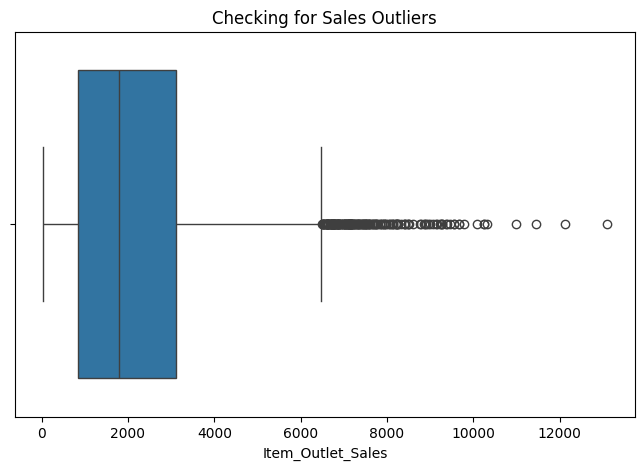

In [12]:
# Detecting outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x=df['Item_Outlet_Sales'])
plt.title('Checking for Sales Outliers')
plt.show()

In [13]:
# Identifying the Outlier Threshold
Q1 = df['Item_Outlet_Sales'].quantile(0.25)
Q3 = df['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Lower Limit: {lower_limit}")
print(f"Upper Limit: {upper_limit}")

Lower Limit: -2566.3261
Upper Limit: 6501.8699


In [14]:
# Handling the Outliers
df['Item_Outlet_Sales'] = np.log1p(df['Item_Outlet_Sales'])

In [15]:
# Stripping spaces from all object columns
obj_cols = df.select_dtypes(include=['object']).columns
for col in obj_cols:
    df[col] = df[col].str.strip()

# Analyzing

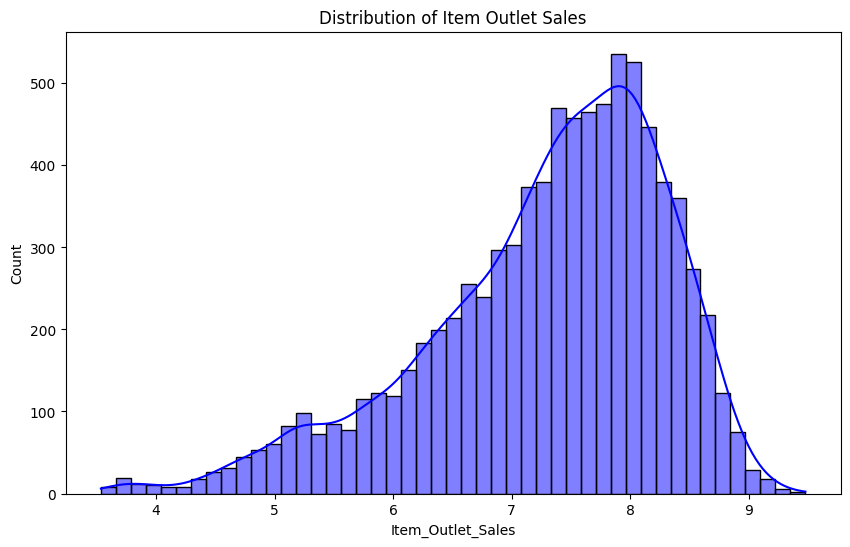

In [16]:
# Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Item_Outlet_Sales'], kde=True, color='blue')
plt.title('Distribution of Item Outlet Sales')
plt.show()

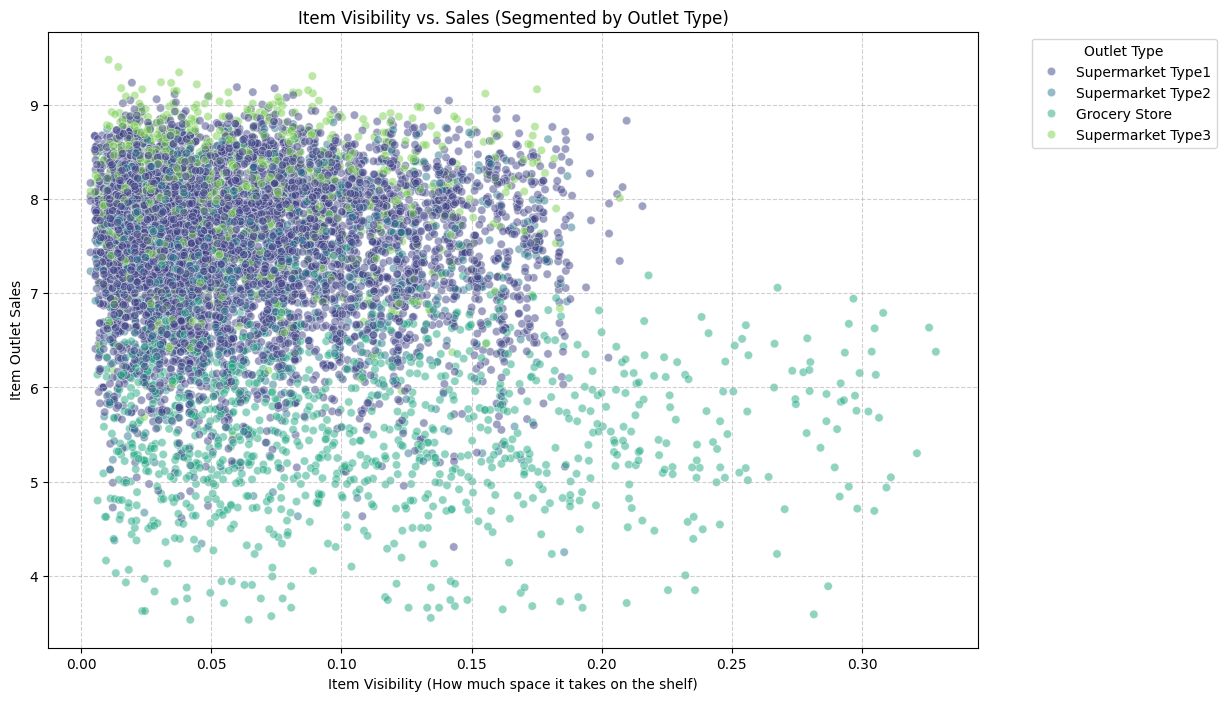

In [17]:
# Item_Visibility vs Item_Outlet_Sales by Outlet_Type
plt.figure(figsize=(12, 8))

# Using hue to separate the data by Outlet Type
# alpha=0.5 helps see where points overlap (density)
sns.scatterplot(
    x='Item_Visibility', 
    y='Item_Outlet_Sales', 
    hue='Outlet_Type', 
    data=df, 
    alpha=0.5,
    palette='viridis')

plt.title('Item Visibility vs. Sales (Segmented by Outlet Type)')
plt.xlabel('Item Visibility (How much space it takes on the shelf)')
plt.ylabel('Item Outlet Sales')
plt.legend(title='Outlet Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

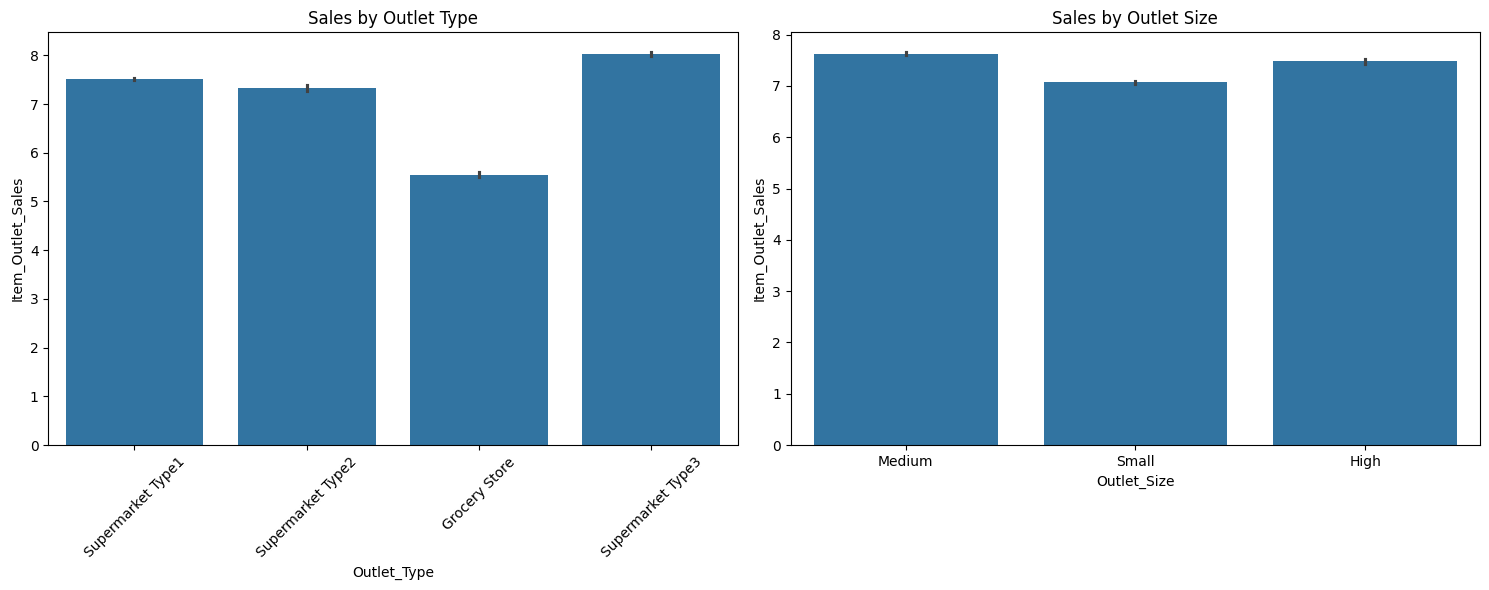

In [18]:
# Sales by Outlet Type and Size
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sales by Outlet Type
sns.barplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Sales by Outlet Type')

# Sales by Outlet Size
sns.barplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df, ax=axes[1])
axes[1].set_title('Sales by Outlet Size')

plt.tight_layout()
plt.show()

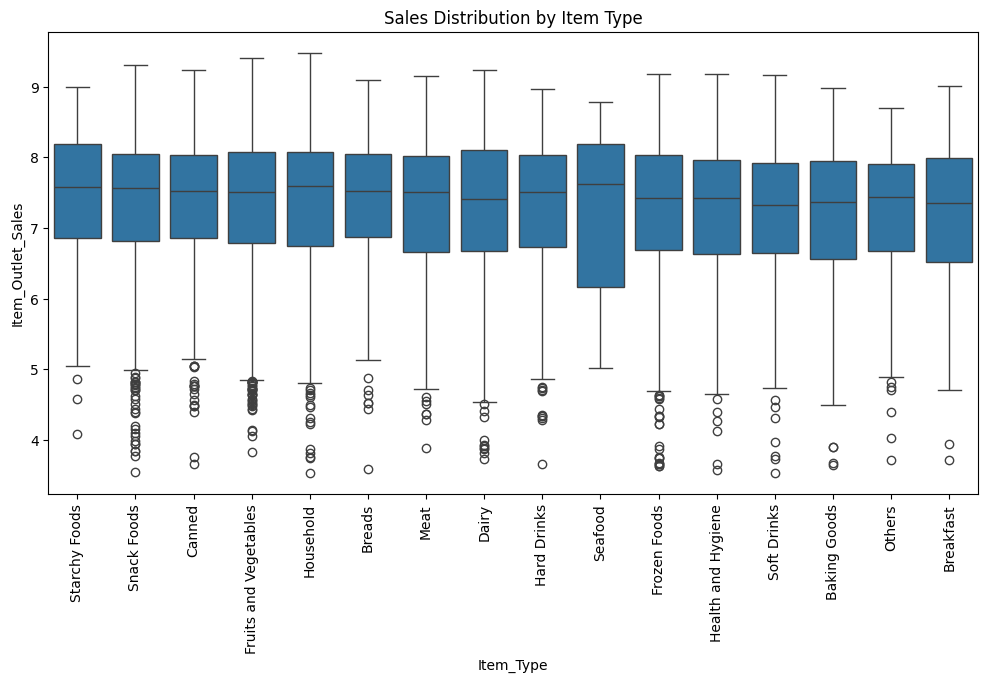

In [19]:
# Categories which are Cash Cows
plt.figure(figsize=(12, 6))
order = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).index
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=df, order=order)
plt.xticks(rotation=90)
plt.title('Sales Distribution by Item Type')
plt.show()

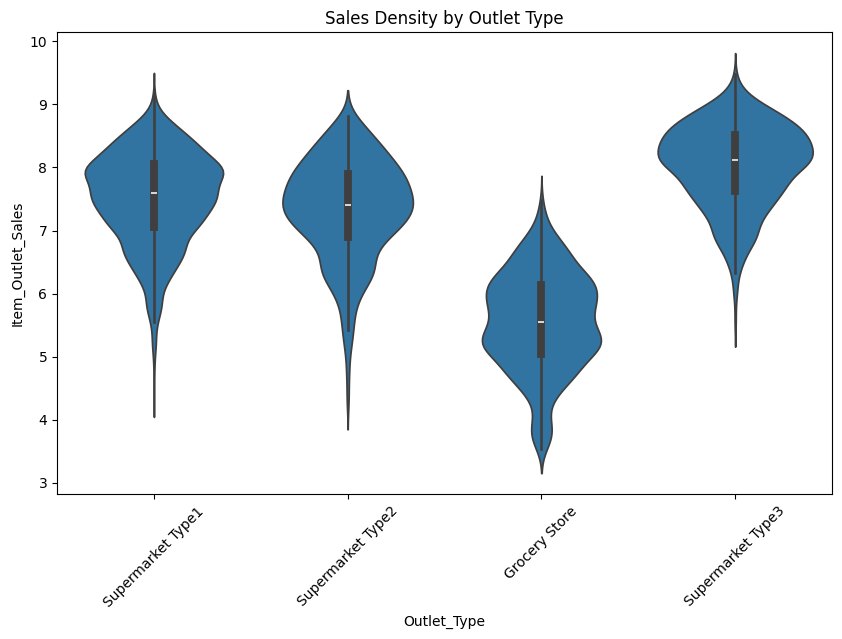

In [20]:
# Comparing Sales across different Store Types
plt.figure(figsize=(10,6))
sns.violinplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df)
plt.title('Sales Density by Outlet Type')
plt.xticks(rotation=45)
plt.show()